In [1]:
import os,csv,re,sys
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
import random, torch
from sklearn import metrics
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
BASE_PATH = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/data/DLPFC')
output_path = Path('/home/lytq/Spatial-Transcriptomics-Benchmark/RESULTS/DLPFC/SpaGCN')
sample_name = '151673'


In [3]:
dir_input = Path(f'{BASE_PATH}/{sample_name}/')
dir_output = Path(f'{output_path}/{sample_name}/')
dir_output.mkdir(parents=True, exist_ok=True)

if sample_name in ['151669', '151670', '151671', '151672']:
    n_clusters = 5
else:
    n_clusters = 7

In [4]:
adata = sc.read_visium(f'{dir_input}')
adata.var_names_make_unique()

spatial=pd.read_csv(f"{dir_input}/spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0)

adata.obs["x1"]=spatial[1]
adata.obs["x2"]=spatial[2]
adata.obs["x3"]=spatial[3]
adata.obs["x4"]=spatial[4]
adata.obs["x5"]=spatial[5]

adata=adata[adata.obs["x1"]==1]
adata.var_names=[i.upper() for i in list(adata.var_names)]
adata.var["genename"]=adata.var.index.astype("str")
# adata.write_h5ad(f"{dir_output}/sample_data.h5ad")

#Read in hitology image
img=cv2.imread(f"{dir_input}/spatial/{sample_name}_full_image.tif")

#Set coordinates
adata.obs["x_array"]=adata.obs["x2"]
adata.obs["y_array"]=adata.obs["x3"]
adata.obs["x_pixel"]=adata.obs["x4"]
adata.obs["y_pixel"]=adata.obs["x5"]
x_array=adata.obs["x_array"].tolist()
y_array=adata.obs["y_array"].tolist()
x_pixel=adata.obs["x_pixel"].tolist()
y_pixel=adata.obs["y_pixel"].tolist()

#Test coordinates on the image
img_new=img.copy()
for i in range(len(x_pixel)):
    x=x_pixel[i]
    y=y_pixel[i]
    img_new[int(x-20):int(x+20), int(y-20):int(y+20),:]=0

# cv2.imwrite(f'{dir_output}/sample_map.jpg', img_new)

/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial'
    obsm: 'spatial'

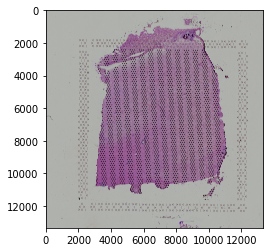

In [6]:
plt.imshow(img_new)

In [7]:
#Calculate adjacent matrix
b=49
a=1
adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=a, histology=True)
# np.savetxt(f'{dir_output}/adj.csv', adj, delimiter=',')


##### Spatial domain detection using SpaGCN
spg.prefilter_genes(adata, min_cells=3) # avoiding all genes are zeros
spg.prefilter_specialgenes(adata)
#Normalize and take log for UMI
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

### 4.2 Set hyper-parameters
p=0.5 
spg.test_l(adj,[1, 10, 100, 500, 1000])
l=spg.find_l(p=p,adj=adj,start=100, end=500,sep=1, tol=0.01)
n_clusters=n_clusters
r_seed=t_seed=n_seed=100
res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, max_epochs=20, r_seed=r_seed, 
                    t_seed=t_seed, n_seed=n_seed)

### 4.3 Run SpaGCN
clf=spg.SpaGCN()
clf.set_l(l)
#Set seed
random.seed(r_seed)
torch.manual_seed(t_seed)
np.random.seed(n_seed)
#Run
clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
y_pred, prob=clf.predict()
adata.obs["pred"]= y_pred
adata.obs["pred"]=adata.obs["pred"].astype('category')
#Do cluster refinement(optional)
adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
adata.obs["refined_pred"]=refined_pred
adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
#Save results
# adata.write_h5ad(f"{dir_output}/results.h5ad")
# adata.obs.to_csv(f'{dir_output}/cell_metadata.csv')


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  33.30687202862215 174.55510595352243 46.84205750749746
Var of x,y,z =  5606737.526317932 4468793.817921193 5606737.526317932
l is  1 Percentage of total expression contributed by neighborhoods: 0.0
l is  10 Percentage of total expression contributed by neighborhoods: 0.0
l is  100 Percentage of total expression contributed by neighborhoods: 0.23831093311309814
l is  500 Percentage of total expression contributed by neighborhoods: 28.014718548210983
l is  1000 Percentage of total expression contributed by neighborhoods: 153.882049263866
L= 100 P= 0.23831
L= 101 P= 0.24709
L= 102 P= 0.25606
L= 103 P= 0.2652
L= 104 P= 0.27454
L= 105 P= 0.28405
L= 106 P= 0.29376
L= 107 P= 0.30365
L= 108 P= 0.31374
L= 109 P= 0.32402
L= 110 P= 0.33449
L= 111 P= 0.34515
L= 112 P= 0.35601
L= 113 P= 0.36707
L= 114 P= 0.37832
L= 115 P= 0.38978
L= 116 P= 0.40144
L= 117 P= 0.41329
L= 118 P= 0.42536
L= 119 P= 0.43763
L= 120 P= 0.4501
L= 121 P= 0.46

/home/lytq/.conda/envs/spagcn/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
recommended res =  0.7
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoch  60
Epoch  70
Epoch  80
Epoch  90
Epoch  100
Epoch  110
Epoch  120
Epoch  130
Epoch  140
Epoch  150
Epoch  160
Epoch  170
Epoch  180
Epoch  190
Calculateing adj matrix using xy only...


In [8]:
adata

AnnData object with n_obs × n_vars = 3639 × 19130
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'refined_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [27]:
plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]


In [9]:
adata

AnnData object with n_obs × n_vars = 3639 × 19130
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'refined_pred'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [10]:
df_meta = pd.read_csv(dir_input / 'metadata.tsv', sep='\t')
adata.obs['layer_guess'] = df_meta['layer_guess']

In [11]:
#Plot spatial domains
domains="pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])

ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
# plt.savefig(f"{dir_output}/clustering.pdf", dpi=300, bbox_inches='tight')


NameError: name 'plot_color' is not defined

In [12]:
adata

AnnData object with n_obs × n_vars = 3639 × 19130
    obs: 'in_tissue', 'array_row', 'array_col', 'x1', 'x2', 'x3', 'x4', 'x5', 'x_array', 'y_array', 'x_pixel', 'y_pixel', 'n_counts', 'pred', 'refined_pred', 'layer_guess'
    var: 'gene_ids', 'feature_types', 'genome', 'genename'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [13]:
adata.obs

,in_tissue,array_row,array_col,x1,x2,x3,x4,x5,x_array,y_array,x_pixel,y_pixel,n_counts,pred,refined_pred,layer_guess
AAACAAGTATCTCCCA-1,1,50,102,1,50,102,8468,9791,50,102,8468,9791,7048.0,3,3,Layer3
AAACAATCTACTAGCA-1,1,3,43,1,3,43,2807,5769,3,43,2807,5769,1463.0,1,1,Layer1
AAACACCAATAACTGC-1,1,59,19,1,59,19,9505,4068,59,19,9505,4068,3337.0,5,5,WM
AAACAGAGCGACTCCT-1,1,14,94,1,14,94,4151,9271,14,94,4151,9271,4115.0,0,0,Layer3
AAACAGCTTTCAGAAG-1,1,43,9,1,43,9,7583,3393,43,9,7583,3393,3624.0,4,4,Layer5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGTTTCACATCCAGG-1,1,58,42,1,58,42,9396,5653,58,42,9396,5653,3953.0,5,5,WM
TTGTTTCATTAGTCTA-1,1,60,30,1,60,30,9630,4825,60,30,9630,4825,2447.0,5,5,WM
TTGTTTCCATACAACT-1,1,45,27,1,45,27,7831,4631,45,27,7831,4631,1845.0,6,6,Layer6
TTGTTTGTATTACACG-1,1,73,41,1,73,41,11193,5571,73,41,11193,5571,2021.0,6,6,WM


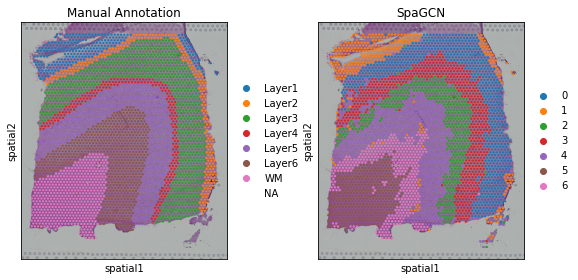

In [16]:
# adata.obsm['']
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sc.pl.spatial(adata, color='layer_guess', ax=axes[0], show=False)
sc.pl.spatial(adata, color='refined_pred', ax=axes[1], spot_size=100, show=False)
axes[0].set_title('Manual Annotation')
axes[1].set_title('SpaGCN')
plt.tight_layout()
plt.show()

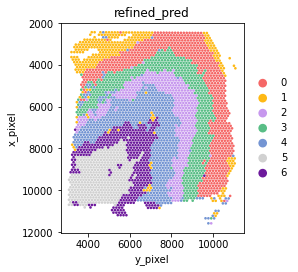

In [31]:
#Plot refined spatial domains
domains="refined_pred"
num_celltype=len(adata.obs[domains].unique())
adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
ax.set_aspect('equal', 'box')
ax.axes.invert_yaxis()
# plt.savefig(f"{dir_output}/refined_clustering.pdf", dpi=300, bbox_inches='tight')
# plt.close()


In [32]:

df_meta = pd.read_csv(f'{dir_input}/metadata.tsv', sep='\t')
df_meta['SpaGCN'] = adata.obs["refined_pred"].tolist()
df_meta.to_csv(f'{dir_output}/cell_metadata.csv', index=False)
df_meta = df_meta[~pd.isnull(df_meta['layer_guess'])]
ARI = metrics.adjusted_rand_score(df_meta['layer_guess'], df_meta['SpaGCN'])
print('===== Project: {} ARI score: {:.3f}'.format(sample_name, ARI))
ARI_list.append(ARI)

===== Project: 151673 ARI score: 0.461


NameError: name 'ARI_list' is not defined